In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/facial-keypoints-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('facial-keypoints-detection')

with zipfile.ZipFile('/content/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facial-keypoints-detection/test')

with zipfile.ZipFile('/content/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facial-keypoints-detection/training')

train = pd.read_csv('/content/facial-keypoints-detection/training/training.csv')
test = pd.read_csv('/content/facial-keypoints-detection/test/test.csv')
id = pd.read_csv('/content/facial-keypoints-detection/IdLookupTable.csv')

print(train.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [ ]:
train.head(3).T

,0,1,2
left_eye_center_x,66.033564,64.332936,65.057053
left_eye_center_y,39.002274,34.970077,34.909642
right_eye_center_x,30.227008,29.949277,30.903789
right_eye_center_y,36.421678,33.448715,34.909642
left_eye_inner_corner_x,59.582075,58.85617,59.412
left_eye_inner_corner_y,39.647423,35.274349,36.320968
left_eye_outer_corner_x,73.130346,70.722723,70.984421
left_eye_outer_corner_y,39.969997,36.187166,36.320968
right_eye_inner_corner_x,36.356571,36.034723,37.678105
right_eye_inner_corner_y,37.389402,34.361532,36.320968


In [ ]:
display(test.head())

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
complete_train = train[~train.isnull().any(axis=1)]
incomplete_train = train[train.isnull().any(axis=1)]

print(f"Samples with 15 keypoints: {len(complete_train)}")
print(f"Samples with 4 keypoints: {len(incomplete_train)}")

Samples with 15 keypoints: 2140
Samples with 4 keypoints: 4909


In [ ]:
def process_training_data(data):
    images = []
    keypoints = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int), (96,96,1))
      images.append(image)
      keypoints.append(sample.drop('Image'))

    keypoints = np.array(keypoints, dtype = 'float')
    images = np.array(images)/255.
    return images, keypoints

X_train, y_train = process_training_data(complete_train)

print(X_train.shape)
print(y_train.shape)

(2140, 96, 96, 1)
(2140, 30)


In [ ]:
def process_test_data(data):
    images = []
    for idx, sample in data.iterrows():
      image = np.reshape(np.array(sample['Image'].split(' '), dtype=int),(96,96,1))
      images.append(image)

    images = np.array(images)/255.
    return images

X_test = process_test_data(test)
print(X_test.shape)

(1783, 96, 96, 1)


In [ ]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Flatten, Dropout, MaxPool2D, LeakyReLU, GlobalAveragePooling2D, Reshape
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, \
    Flatten, Dense, Dropout, Conv2D, MaxPool2D, ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pickle

In [ ]:
model = Sequential()

model.add(Convolution2D(16, (3,3), padding='same', use_bias=False, input_shape = (96, 96, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(16, (3,3), padding='same', use_bias=False, input_shape = (96, 96, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae', 'acc'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_269 (Conv2D)         (None, 96, 96, 16)        144       
                                                                 
 leaky_re_lu_269 (LeakyReLU  (None, 96, 96, 16)        0         
 )                                                               
                                                                 
 batch_normalization_269 (B  (None, 96, 96, 16)        64        
 atchNormalization)                                              
                                                                 
 conv2d_270 (Conv2D)         (None, 96, 96, 16)        2304      
                                                                 
 leaky_re_lu_270 (LeakyReLU  (None, 96, 96, 16)        0         
 )                                                               
                                                     

In [ ]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
optimizer = Adam(learning_rate= 1e-3)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'acc'])
es = EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(X_training, y_training, epochs = 20, batch_size = 128, validation_data=(X_validation, y_validation), callbacks=[es])

Epoch 1/20
16/16 [==============================] - 87s 5s/step - loss: 1946.3392 - mae: 39.7180 - acc: 0.0635 - val_loss: 2147.3318 - val_mae: 42.6869 - val_acc: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 81s 5s/step - loss: 359.7392 - mae: 14.6068 - acc: 0.1372 - val_loss: 2575.5344 - val_mae: 44.7968 - val_acc: 0.7103
Epoch 3/20
16/16 [==============================] - 80s 5s/step - loss: 179.9173 - mae: 10.3799 - acc: 0.3424 - val_loss: 766.4008 - val_mae: 25.0599 - val_acc: 0.7103
Epoch 4/20
16/16 [==============================] - 79s 5s/step - loss: 127.9299 - mae: 8.7794 - acc: 0.3399 - val_loss: 13805.9307 - val_mae: 109.3416 - val_acc: 0.7103
Epoch 5/20
16/16 [==============================] - 81s 5s/step - loss: 90.6314 - mae: 7.5142 - acc: 0.3448 - val_loss: 97.0717 - val_mae: 8.4742 - val_acc: 0.7103
Epoch 6/20
16/16 [==============================] - 79s 5s/step - loss: 78.9859 - mae: 7.0058 - acc: 0.3517 - val_loss: 582.3676 - val_mae: 22.3210 - val_a

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
val_predictions = model.predict(X_val)

if len(y_val.shape) == 1 or y_val.shape[1] == 1:
    val_predictions_classes = (val_predictions > 0.5).astype(int)
    y_val_classes = (y_val > 0.5).astype(int)
else:
    # Example for Multi-Class Classification
    # Convert predictions to class labels
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    # Convert y_val to class labels if it is one-hot encoded
    if y_val.ndim == 2:
        y_val_classes = np.argmax(y_val, axis=1)
    else:
        y_val_classes = y_val

# Calculate accuracy
val_accuracy = accuracy_score(y_val_classes, val_predictions_classes)

print(f'Validation Accuracy: {val_accuracy}')


14/14 [==============================] - 5s 346ms/step
Validation Accuracy: 0.7149532710280374


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score

# If your target variable is continuous (regression task), you can use r2_score
if len(y_val.shape) == 1 or y_val.shape[1] == 1:
    r2 = r2_score(y_validation, val_pred)
    print(f'R2 Score: {r2}')

# If your target variable is categorical (classification task), you can use precision, recall, and f1-score
else:
    # Assuming y_val and val_pred are one-hot encoded, get the class with the highest probability
    y_val_classes = y_val.argmax(axis=1)
    val_pred_classes = val_predictions.argmax(axis=1)

    precision = precision_score(y_val_classes, val_pred_classes, average='weighted')
    recall = recall_score(y_val_classes, val_pred_classes, average='weighted')
    f1 = f1_score(y_val_classes, val_pred_classes, average='weighted')

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

Precision: 0.5111581797536903
Recall: 0.7149532710280374
F1 Score: 0.5961190761160203


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_pred = model.predict(X_test)

56/56 [==============================] - 14s 253ms/step


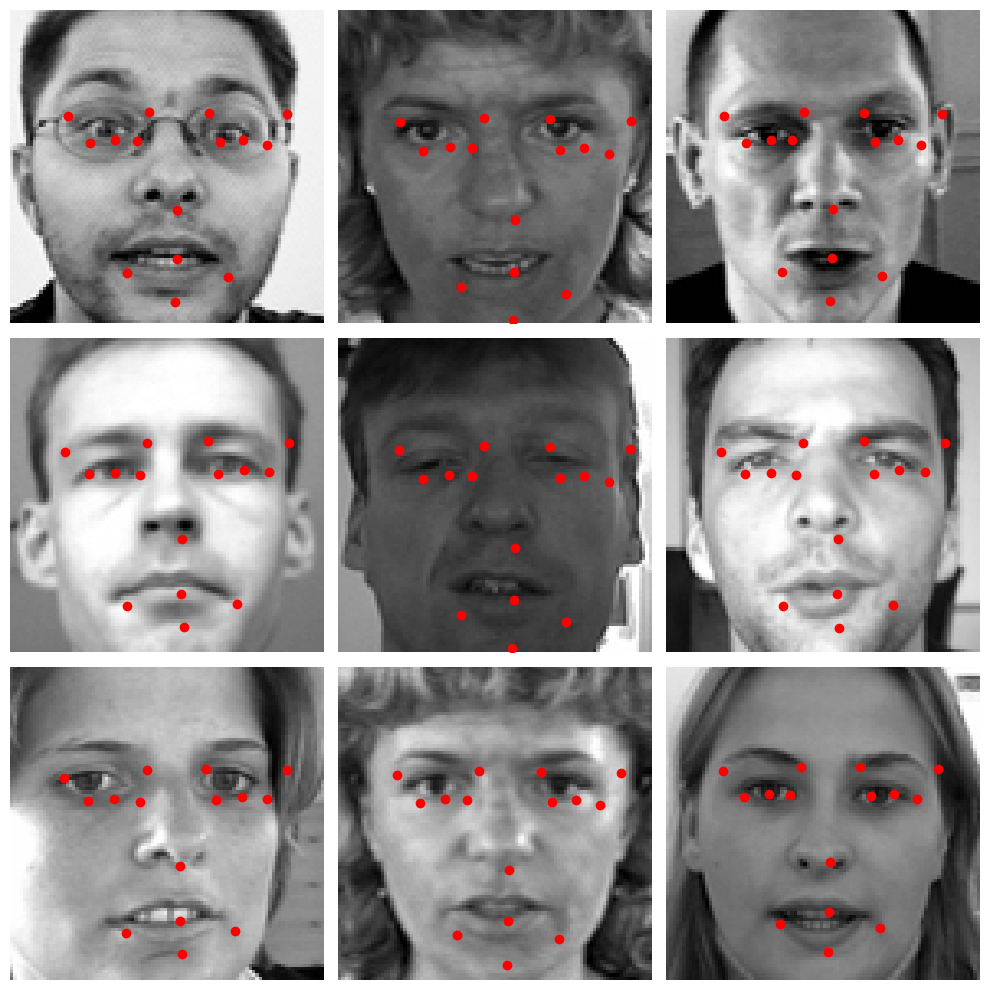

In [72]:
def plot_image_with_keypoints(image, keypoints, ax):
    ax.imshow(image.reshape(96, 96), cmap='gray')
    for i in range(0, len(keypoints), 2):
        ax.scatter(keypoints[i], keypoints[i+1], color='red')
    ax.axis('off')

# Plot 9 images with keypoints
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < 9:
        plot_image_with_keypoints(X_test[i], test_pred[i], ax)

plt.tight_layout()
plt.savefig('CNN_output.png')
plt.show()